# PINN: Physics-Informed Neural Network

## Solve a singular perturbation differential equation
$$ \epsilon \frac{d^2u(x)}{dx^2} + (1+x) \frac{du(x)}{dx} + u(x) = 0 $$
$f(x)$: Given function  
$u(0)=u(1)=1$: Given boundary condition  
$\epsilon=0.01$: Given small constant parameter  


### PINNにおけるニューラルネットワーク構造の工夫
- ニューラルネットワークは、適切な条件の下で任意の連続関数を近似可能な表現力を持つ（普遍近似定理）。しかしあくまでこれは近似可能性を保証しているだけで、最適なニューラルネットワークが実現できるか、学習が効率的に進むかは別問題。
- このノートブックでは、解に異なる長さスケールが現れる境界層問題（特異摂動問題）を例に、ニューラルネットワーク構造の工夫により、学習効率が劇的に変わり得ることを示す。

In [1]:
# ----------------------------
# 問題パラメータ
# ----------------------------
epsilon = 0.01


# ----------------------------
# 必要なライブラリのインポート
# ----------------------------
import jax                         # JAX: 高速な数値計算・自動微分・JITコンパイルを提供するライブラリ
import jax.numpy as jnp            # JAX版NumPy: GPU/TPU対応の数値計算モジュール
from flax import nnx               # Flax NNX: JAX向けのニューラルネットワーク構築ライブラリ
import optax                       # Optax: JAX向けの最適化アルゴリズム（SGD, Adamなど）を提供するライブラリ
import matplotlib.pyplot as plt    # Matplotlib: グラフ描画ライブラリ（可視化に使用）
from scipy.stats.qmc import Sobol  # Sobol列: 準乱数系列（均一な点配置に使える）
from time import time as timer     # 時間計測関数（処理時間測定）
import numpy as np
from scipy.integrate import solve_bvp

# ----------------------------
# ニューラルネットワークモデルの定義(MLP: 多層パーセプトロン)
# ----------------------------
class MLP(nnx.Module):
    def __init__(self, *, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(in_features=1, out_features=64, rngs=rngs)  # 1次元入力ベクトル → 64
        self.linear2 = nnx.Linear(in_features=64, out_features=64, rngs=rngs) # 64 → 64
        self.linear3 = nnx.Linear(in_features=64, out_features=1, rngs=rngs)  # 64 → 1次元出力ベクトル

    def __call__(self, x):            # x: (N, D) ... D 次元ベクトルを N セット入力
        x = nnx.tanh(self.linear1(x)) # 全結合線形変換の後、tanh活性化関数を施す
        x = nnx.tanh(self.linear2(x)) # 全結合線形変換の後、tanh活性化関数を施す
        x = self.linear3(x)           # 最終層は全結合線形変換のみ
        return x                      # x: (N, K) ... K 次元ベクトルを N セット出力

# ----------------------------
# ニューラルネットワークモデルの定義(MatchedMLP: 漸近接続NN-MLP接合型)
# ----------------------------
class MatchedMLP(nnx.Module):
    def __init__(self, *, rngs: nnx.Rngs,
                 delta: float=0.01, width: float=0.05, center: float=0.1):
        self.model_in = MLP(rngs=rngs)
        self.model_out = MLP(rngs=rngs)
        self.delta = delta
        self.width = width
        self.center = center

    def smooth_mask(self, x):
        return 0.5 * (1.0 - jnp.tanh((x - self.center) / self.width))

    def __call__(self, x):
        xi = x / self.delta
        y_in = self.model_in(xi)
        y_out = self.model_out(x)
        w = self.smooth_mask(x)
        return w * y_in + (1 - w) * y_out

# ----------------------------
# PINN 境界層問題 ソルバークラス
# ----------------------------
class PINN_BL():
    def __init__(self, nn_model: nnx.Module, lr: float = 1e-3):
        self.nn_model = nn_model # ニューラルネットワークモデル
        self.optimizer = nnx.Optimizer(self.nn_model, optax.adam(lr)) # 最適化器 (Adam)
        self.metrics = nnx.metrics.Average('loss') # 損失関数値を追跡するメトリクス

    # ニューラルネットワークの学習（モデル更新）
    def train(self, x_col, f_col, x_obs, u_obs, n_epochs=1500):
        for epoch in range(n_epochs + 1):
            jit_train_step(self.nn_model, self.optimizer, self.metrics, x_col, f_col, x_obs, u_obs)
            if epoch % (n_epochs // 10) == 0:
                print(f"[Epoch {epoch}] loss={self.metrics.compute()}")

    # 学習済みモデルを使って予測
    def predict(self, x):
        return self.nn_model(x)[:, 0]

# ----------------------------
# 学習ステップの定義
#    Just-in-time (JIT)コンパイルによる高速化のため、外部関数として定義
# ----------------------------
@nnx.jit
def jit_train_step(model: nnx.Module, optimizer: nnx.Optimizer, metrics: nnx.metrics.Average,
                   x_col, f_col, x_obs, u_obs):
  
    def loss_fn(m: nnx.Module):
        # --- PDE項（Poisson方程式の残差） ---
        def u_fn(x_scalar):
            return m(jnp.array(x_scalar).reshape(1,1))[0,0]
        dudx_fn = jax.grad(u_fn, argnums=0)
        d2udx2_fn = jax.jacfwd(dudx_fn, argnums=0)
        res = jax.vmap(lambda x: 
                       epsilon * d2udx2_fn(x)[0,0] + (1 + x) * dudx_fn(x)[0] + u_fn(x))(x_col)
                       # PDE残差項：εd²u/dx² + (1+x)du/dx + u
        loss_pde = jnp.mean(res**2) # PDE損失（平均二乗誤差）
        
        # --- データ項（観測値とNN出力の誤差） ---
        u_pred = m(x_obs)[:, 0]                # 観測点におけるNN出力（shape: (N_obs,)）
        loss_data = jnp.mean((u_pred - u_obs)**2) # データ損失（平均二乗誤差）
        
        # --- 全体損失（同等重みで和を取る） ---
        return loss_pde + loss_data

    loss, grads = nnx.value_and_grad(loss_fn)(model) # 損失とその勾配を計算
    optimizer.update(grads)   # オプティマイザに勾配を渡し、NNモデルパラメータを上書き更新
    metrics.update(loss=loss) # 損失を記録
    return

### PINN learning 1: Regular MLP
[Epoch 0] loss=1.2462446689605713
[Epoch 100] loss=0.3607676327228546
[Epoch 200] loss=0.22859880328178406
[Epoch 300] loss=0.18349319696426392
[Epoch 400] loss=0.16079005599021912
[Epoch 500] loss=0.14713476598262787
[Epoch 600] loss=0.13801756501197815
[Epoch 700] loss=0.13149909675121307
[Epoch 800] loss=0.126607283949852
[Epoch 900] loss=0.12280109524726868
[Epoch 1000] loss=0.1197548359632492
Elapsed time [sec] = 1.042804479598999
### PINN learning 2: Asymptotic-Matched MLP
[Epoch 0] loss=166.1707763671875
[Epoch 100] loss=6.124955654144287
[Epoch 200] loss=3.3202617168426514
[Epoch 300] loss=2.2870259284973145
[Epoch 400] loss=1.7368767261505127
[Epoch 500] loss=1.3963598012924194
[Epoch 600] loss=1.1660698652267456
[Epoch 700] loss=1.0004650354385376
[Epoch 800] loss=0.8758571743965149
[Epoch 900] loss=0.7787268161773682
[Epoch 1000] loss=0.7010258436203003
Elapsed time [sec] = 1.6917452812194824


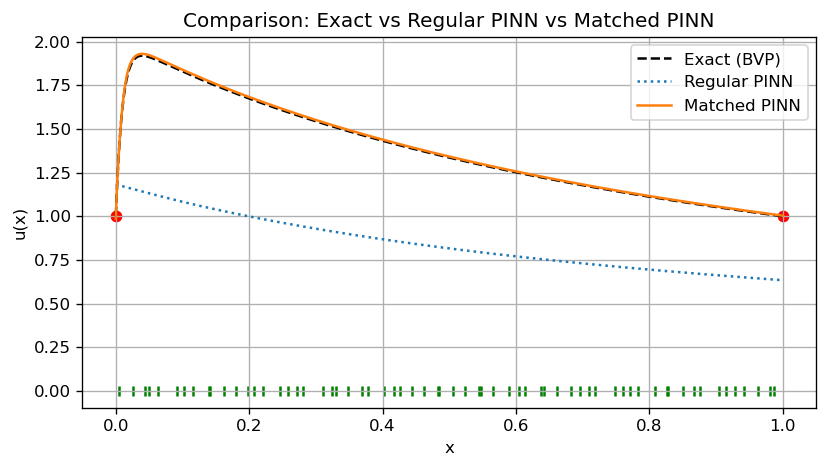

In [2]:
# ----------------------------
# メイン実行ブロック
# ----------------------------

# --- 問題定義 ---
D = 1  # 入力の次元数（ここでは1次元のPoisson方程式を対象）
f_fn = lambda x: jnp.zeros_like(x[:, 0]) # 右辺関数 f(x)（JAX配列対応）
x_obs = jnp.array([[0.0], [1.0]])  # 観測点 x（境界条件などに対応）
u_obs = jnp.array([1.0, 1.0])      # 観測値 u(x)（境界値など）

# --- PDE評価位置 (Collocation points) の選定 ---
sampler = Sobol(d=D, scramble=True, seed=0)  # Sobol点列（低偏差系列）でほぼ均質な乱数配置
x_col = jnp.array(sampler.random_base2(m=6)) # 2^6 = 64個のCollocation
f_col = f_fn(x_col).reshape(-1, 1)           # f(x)をCollocation点で評価（(64,1)

# --- PINN学習 ---
print("### PINN learning 1: Regular MLP")
pinn_mlp = PINN_BL(MLP(rngs=nnx.Rngs(0))) # PINNソルバーインスタンス(通常のMLP)を作成
t0 = timer()
pinn_mlp.train(x_col, f_col, x_obs, u_obs, n_epochs=1000) # 上記問題に対して学習実行
t1 = timer(); print("Elapsed time [sec] =", t1 - t0)

print("### PINN learning 2: Asymptotic-Matched MLP")
pinn_matched = PINN_BL(MatchedMLP(rngs=nnx.Rngs(0),delta=epsilon)) # PINNソルバーインスタンス(MatchedMLP)を作成
t0 = timer()
pinn_matched.train(x_col, f_col, x_obs, u_obs, n_epochs=1000) # 上記問題に対して学習実行
t1 = timer(); print("Elapsed time [sec] =", t1 - t0)

# --- 予測と可視化 ---
x_plot = jnp.linspace(0, 1, 2000).reshape(-1, D) # 可視化用の均等点（200点）
u_mlp = pinn_mlp.predict(x_plot)                 # 学習済みモデルで予測
u_matched = pinn_matched.predict(x_plot)         # 学習済みモデルで予測

# --- 結果比較用の厳密解 (scipy.solv_bvp) ---
x_np = np.linspace(0, 1, 2000)
y_init = np.ones((2, x_np.size))
y0 = float(u_obs[0])
y1 = float(u_obs[1])
def bvp_func(x, y):
    dydx = y[1]
    d2ydx2 = (-(1 + x) * y[1] - y[0]) / epsilon
    return np.vstack((dydx, d2ydx2))
def bc(ya, yb):
    return np.array([ya[0] - y0, yb[0] - y1])
sol = solve_bvp(bvp_func, bc, x_np, y_init)
u_exact = sol.sol(x_np)[0]

fig = plt.figure(figsize=(7,4), dpi=120)
ax = fig.add_subplot()
ax.plot(x_np, u_exact, '--k', label="Exact (BVP)")
ax.scatter(x_obs[:, 0], u_obs, c="red")#, label="BC")
ax.scatter(x_col[:, 0], jnp.zeros_like(x_col[:, 0]), marker="|", c="green")#, label="Colloc.")
ax.plot(x_plot, u_mlp, ':', label="Regular PINN")
ax.plot(x_plot, u_matched, '-', label="Matched PINN")
# plt.plot(x, y_matched_at, '-.', label="Matched PINN (Auto tune)")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Comparison: Exact vs Regular PINN vs Matched PINN")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
# # ----------------------------
# # ニューラルネットワークモデルの定義(MatchedMLP_autotune: 漸近接続NN-MLP接合型, 接合位置・幅自動チューニング)
# # ----------------------------
# class MatchedMLP_autotune(nnx.Module):
#     def __init__(self, *, rngs: nnx.Rngs, init_delta: float=0.01):
#         self.model_in = MLP(rngs=rngs)
#         self.model_out = MLP(rngs=rngs)
#         sqrt_delta = jnp.sqrt(init_delta)
#         # delta, width, centerを学習可能パラメータとして登録（初期値は適当に指定）
#         self.delta = nnx.Param(init_delta)
#         self.width = nnx.Param(sqrt_delta*5)
#         self.center = nnx.Param(sqrt_delta)

#     def smooth_mask(self, x):
#         return 0.5 * (1.0 - jnp.tanh((x - self.center) / self.width))

#     def __call__(self, x):
#         xi = x / self.delta
#         y_in = self.model_in(xi)
#         y_out = self.model_out(x)
#         w = self.smooth_mask(x)
#         return w * y_in + (1 - w) * y_out

# # --- PINN学習 ---
# print("### PINN learning 3: Asymptotic-Matched MLP (Auto tune)")
# pinn_matched_at = PINN_BL(MatchedMLP_autotune(rngs=nnx.Rngs(0),init_delta=epsilon)) # PINNソルバーインスタンス(MatchedMLP_autotune)を作成
# t0 = timer()
# pinn_matched_at.train(x_col, f_col, x_obs, u_obs, n_epochs=1000) # 上記問題に対して学習実行
# t1 = timer(); print("Elapsed time [sec] =", t1 - t0)

# # --- 予測と可視化 ---
# u_matched_at = pinn_matched_at.predict(x_plot) # 学習済みモデルで予測

# fig = plt.figure(figsize=(7,4), dpi=120)
# ax = fig.add_subplot()
# ax.plot(x_np, u_exact, '--k', label="Exact (BVP)")
# ax.scatter(x_obs[:, 0], u_obs, c="red")#, label="BC")
# ax.scatter(x_col[:, 0], jnp.zeros_like(x_col[:, 0]), marker="|", c="green")#, label="Colloc.")
# ax.plot(x_plot, u_mlp, ':', label="Regular PINN")
# ax.plot(x_plot, u_matched, '-', label="Matched PINN")
# plt.plot(x_plot, u_matched_at, '-.', c="C3", label="Matched PINN (Auto tune)")
# plt.xlabel("x")
# plt.ylabel("u(x)")
# plt.title("Comparison: Exact vs Regular PINN vs Matched PINN")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [4]:
# print("delta:", float(pinn_matched_at.nn_model.delta), epsilon)
# print("width:", float(pinn_matched_at.nn_model.width), np.sqrt(epsilon))
# print("center:", float(pinn_matched_at.nn_model.center), np.sqrt(epsilon)*5)

# fig = plt.figure(figsize=(7,4), dpi=120)
# ax = fig.add_subplot()
# ax.plot(x_np, u_exact, '--k', label="Exact (BVP)")
# ax.scatter(x_obs[:, 0], u_obs, c="red")#, label="BC")
# # ax.scatter(x_col[:, 0], jnp.zeros_like(x_col[:, 0]), marker="|", c="green")#, label="Colloc.")
# ax.plot(x_plot, u_mlp, ':', label="Regular PINN")
# ax.plot(x_plot, u_matched, '-', label="Matched PINN")
# ax.plot(x_plot, u_matched_at, '-.', c="C3", label="Matched PINN (Auto tune)")
# ax.set_xlabel("x")
# ax.set_ylabel("u(x)")
# ax.set_xlim(-epsilon,2*np.sqrt(epsilon))
# ax.set_title("Comparison: Exact vs Regular PINN vs Matched PINN")
# ax.grid(True)
# ax.legend()
# fig.tight_layout()
# plt.show()